In [1]:
# Importing modules and libraries including custom scripts
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.stats import spearmanr
import time
from scipy import sparse

Loading data

In [2]:
# Load citation data from CSV
# Columns: 
# [0] citing_id – the ID of the citing paper
# [1] cited_id  – the ID of the cited paper
path = '/lustre/b192aa/b192aa36/input/citations.csv'

citations_df = pd.read_csv(path, header=None) 

print(citations_df.head())

                                          0  \
0                                 citing_id   
1  79b1c84af0aea452e8bbfbff8f5ef35edd1e0ceb   
2  79b1c84af0aea452e8bbfbff8f5ef35edd1e0ceb   
3  43981a8e26a5a82f6f852f9fb1734e716663a65b   
4  43981a8e26a5a82f6f852f9fb1734e716663a65b   

                                          1  
0                                  cited_id  
1  593f3310f774aa826c656b65c8cbc12a96961904  
2  25b3e47fb7413c7b4aa3de6a94f126a472559112  
3  9a8fbfe897e0b60e2cc939cbba069345f6253cc7  
4  62b048f93b98e2a42cd18a3d4155e33c1739bc51  


In [3]:
citations_df.columns = ['citing_id', 'cited_id']

Manual

In [4]:
g_start1 = time.time()
adj_dict = citations_df.groupby('citing_id')['cited_id'].apply(list).to_dict()
g_end1   = time.time()
print(f"Building an adjacent dictionary took {g_end1 - g_start1:.4f} seconds")

Building an adjacent dictionary took 430.6377 seconds


In [5]:
def pagerank(graph_dict, alpha: float = 0.85, max_steps: int = 100, tolerance: float = 1e-6):
    """
    Compute PageRank scores for a directed graph using power iteration

    Parameters
    ----------
    graph_dict : dict
        Dictionary mapping source nodes to lists of target nodes (adjacency list)
    alpha : float
        Damping factor
    max_steps : int
        Maximum number of iterations to perform
    tolerance : float
        Convergence threshold for L1 norm between iterations

    Returns
    -------
    pagerank_scores : dict
        Dictionary mapping each node to its PageRank score
    """
    # Gather all unique nodes in the graph
    node_set = set(graph_dict.keys()) # O(N)
    
    for targets in graph_dict.values(): # O(E)
        node_set.update(targets)

    node_list = list(node_set)
    num_nodes = len(node_list)

    # Map node labels to matrix indices
    node_index = {node: i for i, node in enumerate(node_list)}

    # Build transition matrix in sparse format
    out_degree = np.zeros(num_nodes, dtype=np.int32)
    row_indices, col_indices, values = [], [], []

    for source, targets in graph_dict.items():
        src_idx = node_index[source]
        num_targets = len(targets)
        out_degree[src_idx] = num_targets # for handling dangling nodes

        if num_targets > 0:
            weight = 1.0 / num_targets
            for target in targets:
                tgt_idx = node_index[target]
                # Build M such that M[tgt, src] = 1 / out_deg[src]
                row_indices.append(tgt_idx)
                col_indices.append(src_idx)
                values.append(weight)

    # Create a compressed sparse row matrix
    transition_matrix = sparse.csr_matrix((values, (row_indices, col_indices)), shape=(num_nodes, num_nodes))

    # Identify dangling nodes (no outbound links)
    dangling_nodes = np.where(out_degree == 0)[0] # O(N)

    # Initialize PageRank vector with uniform values
    rank = np.ones(num_nodes) / num_nodes
    teleportation = (1.0 - alpha) / num_nodes

    # Run the power iteration algorithm
    for _ in range(max_steps): # O(100) for max_steps=100
        dangling_sum = rank[dangling_nodes].sum() 
        updated_rank = alpha * (transition_matrix.dot(rank) + dangling_sum / num_nodes) + teleportation
        delta = np.abs(updated_rank - rank).sum()
        rank = updated_rank
        if delta < tolerance:
            break

    # Map final scores back to original node labels
    pagerank_scores = {node: float(rank[node_index[node]]) for node in node_list}
    return pagerank_scores

In [6]:
start1 = time.time()
results = pagerank(adj_dict)
end1   = time.time()
print(f"Custom PageRank Implementation took {end1 - start1:.4f} seconds")

Custom PageRank Implementation took 991.6850 seconds


In [7]:
df_results = (
    pd.DataFrame.from_dict(
        results,
        orient='index',
        columns=['pagerank']      # name the PageRank column “pagerank” right away
    )
    .reset_index()             # brings the keys out as a column named “index”
    .rename(columns={'index':'paper_id'})  # give columns names
)
print(df_results.head())

                                   paper_id      pagerank
0  8014c463399a689d37f96252a97560fd18ba265f  1.454107e-08
1  075315ccf7893f990d595c0d5cac55d97267d84d  1.874736e-08
2  f27199f4a1b92d33b4cec056c9a740df7a5c2520  1.366792e-08
3  f50afb095a8daf134476a2f2504972850725ee06  2.823798e-08
4  b2f9b04f401bba050aac0c70015cfce6e7d18622  1.452558e-08


In [8]:
df_results['pagerank_scaled'] = (df_results['pagerank'] * 1e6).round(2)

In [9]:
# Add a “rank” column (highest PageRank gets rank 1)
df_results['rank'] = (
    df_results['pagerank']
    .rank(method='min', ascending=False)
    .astype(int)
)

NetworkX

In [10]:
# Build a DiGraph from citation DataFrame
g_start2 = time.time()
G = nx.from_pandas_edgelist(
    citations_df,
    source='citing_id',
    target='cited_id',
    create_using=nx.DiGraph()
)
g_end2  = time.time()
print(f"Building a directed graph took {g_end2 - g_start2:.4f} seconds")

Building a directed graph took 1538.1893 seconds


In [11]:
start2 = time.time()
# Compute PageRank
pr_dict = nx.pagerank(
    G,
    alpha=0.85,    # damping factor
    max_iter=100,
    tol=1e-6
)
end2   = time.time()
print(f"NetworkX PageRank Implementation took {end2 - start2:.4f} seconds")

NetworkX PageRank Implementation took 2623.2124 seconds


In [12]:
# Turn the dict into a DataFrame
pr_df = (
    pd.DataFrame
      .from_dict(pr_dict, orient='index', columns=['pagerank'])
      .reset_index()
      .rename(columns={'index':'paper_id'})
)

# sort
pr_df = pr_df.sort_values('pagerank', ascending=False).reset_index(drop=True)

In [13]:
pr_df['pagerank_scaled'] = (pr_df['pagerank'] * 1e6).round(2)

In [14]:
# Add a “rank” column (highest PageRank gets rank 1)
pr_df['rank'] = (
    pr_df['pagerank']
    .rank(method='min', ascending=False)
    .astype(int)
)

Compare

In [15]:
# Merge dfs on paper_id
merged = pd.merge(
    df_results,
    pr_df,
    on='paper_id',
    suffixes=('_res', '_pr')
)

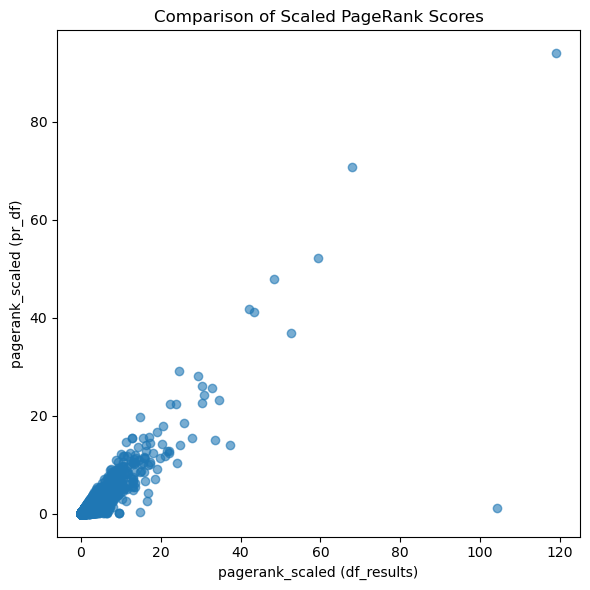

In [16]:
# Scatter plot of scaled PageRank scores
plt.figure(figsize=(6, 6))
plt.scatter(
    merged['pagerank_scaled_res'],
    merged['pagerank_scaled_pr'],
    alpha=0.6
)
plt.xlabel('pagerank_scaled (df_results)')
plt.ylabel('pagerank_scaled (pr_df)')
plt.title('Comparison of Scaled PageRank Scores')
plt.tight_layout()
plt.show()

In [17]:
# Take the top 10 by NetworkX’s PageRank
top10 = (
    merged
    .sort_values('pagerank_res', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# Show both scores side by side
print(top10[['paper_id', 'pagerank_res', 'pagerank_pr']].to_string(index=False))

                                paper_id  pagerank_res  pagerank_pr
8ceb75144ecb846bf463e7565e6a18998ae29d1a      0.000119     0.000094
b4a694952ff9876f4119c90f229716550b57d997      0.000104     0.000001
3d2218b17e7898a222e5fc2079a3f1531990708f      0.000068     0.000071
77ff0bb96b1d085fe284c0a5d87d1d109001afcd      0.000059     0.000052
73f36ff3a6d340606e09d2d0091da27a13af7a6f      0.000053     0.000037
89f4a8ed61c1af384c895984ece7f07148747fdf      0.000048     0.000048
ca5cb4e0826b424adb81cbb4f2e3c88c391a4075      0.000043     0.000041
78510d00faa87970833c79170fc3024817e54c27      0.000042     0.000042
e0a7cdd0e0c9ade81d03ab6515767a2d2d9a90ff      0.000037     0.000014
16c2d2e57c2d64655267b5edb588ff8c0801f1ce      0.000035     0.000023
